In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from scipy.optimize import curve_fit
import math

# Surfactant library

In [2]:
surfactant_library = {
    "SDS": {
        "full_name": "Sodium Dodecyl Sulfate",
        "CAS": "151-21-3",
        "CMC": 8.5,
        "Category": "anionic",
        "MW": 289.39,
        "stock_conc": 50,  # mM
        "low": 7,
        "high": 10
    },


    "NaDC": {
        "full_name": "Sodium Docusate",
        "CAS": "577-11-7",
        "CMC": 5.3375,
        "Category": "anionic",
        "MW": 445.57,
        "stock_conc": 25,  # mM
        "low":2.48,
        "high": 8.2
    },

    
    "NaC": {
        "full_name": "Sodium Cholate",
        "CAS": "361-09-1",
        "CMC": 14,
        "Category": "anionic",
        "MW": 431.56,
        "stock_conc": 50,  # mM
        "low": 13,
        "high":15,
    },


    "CTAB": {
        "full_name": "Hexadecyltrimethylammonium Bromide",
        "CAS": "57-09-0",
        "CMC": 1.07,
        "Category": "cationic",
        "MW": 364.45,
        "stock_conc": 5, # mM
        "low": 0.9,
        "high": 1.24,
    },


    "DTAB": {
        "full_name": "Dodecyltrimethylammonium Bromide",
        "CAS": "1119-94-4",
        "CMC": 15.85,
        "Category": "cationic",
        "MW": 308.34,
        "stock_conc": 50,  # mM
        "low": 15.7,
        "high": 16
    },


    "TTAB": {
        "full_name": "Tetradecyltrimethylammonium Bromide",
        "CAS": "1119-97-7",
        "CMC": 3.985,
        "Category": "cationic",
        "MW": 336.39,
        "stock_conc": 50,  # mM
        "low": 3.77,
        "high": 4.2
    },

    "CAPB": {
        "full_name": "Cocamidopropyl Betaine",
        "CAS": "61789-40-0",
        "CMC": 0.627,
        "Category": "zwitterionic",
        "MW": 342.52,
        "stock_conc": 50,  # mM
        "low": 0.28,
        "high": 0.974
    },
    
    "CHAPS": {
        "full_name": "CHAPS",
        "CAS": "75621-03-3",
        "CMC": 8,
        "Category": "zwitterionic",
        "MW": 614.88,
        "stock_conc": 30,  # mM
        "low": 6,
        "high": 10
    }
}

SURFACTANT_ORDER = ['SDS', 'NaDC', 'NaC', 'CTAB', 'DTAB', 'TTAB', 'CAPB', 'CHAPS']

red = '#e64b35'
blue='#4dbbd5'

# Combine raw data

In [3]:
base_dirs = ['20250708_175050', '20250709_161138', '20250710_115037', '20250710_173246', '20250711_105409', '20250711_151511']

pattern = re.compile(
    r'^(?P<prefix>output_data|wellplate_data)_'         # file type
    r'(?P<surfactant1>[^_-]+)-(?P<ratio1>\d+(?:\.\d+)?)_'  # first surfactant & ratio
    r'(?P<surfactant2>[^_-]+)-(?P<ratio2>\d+(?:\.\d+)?)_'  # second surfactant & ratio
    r'(?P<analysis>fine_fine|rough_rough)\.csv$'           # analysis type
)

# 1) Read & combine output_data
out_dfs = []
for base in base_dirs:
    print (base)
    for path in (Path(base)).glob('output_data_*.csv'):
        m = pattern.match(path.name)
        if not m:
            continue
        surf1 = m.group('surfactant1')
        ratio1 = m.group('ratio1')

        surf2 = m.group('surfactant2')
        ratio2 = m.group('ratio2')

        analysis  = m.group('analysis')

        df = pd.read_csv(path, usecols=['replicate','334_373', '334_384', '600'])
        df['ratio']      = df['334_373'] / df['334_384']
        df['surfactant_1'] = surf1
        df['surfactant_1_ratio'] = ratio1

        df['surfactant_2'] = surf2
        df['surfactant_2_ratio'] = ratio2

        df['analysis']      = analysis

        out_dfs.append(df)

combined_raw = pd.concat(out_dfs, ignore_index=True)

# give each measurement a “row-within-group” index
combined_raw['well_idx'] = (
    combined_raw
      .groupby(['surfactant_1','surfactant_1_ratio','surfactant_2','surfactant_2_ratio','analysis'])
      .cumcount()
)

# 2) Read & combine wellplate_data (no averaging!)
well_dfs = []
for base in base_dirs:
    raw_dir = Path(base)
    for path in raw_dir.glob('wellplate_data_*.csv'):
        m = pattern.match(path.name)
        if not m:
            continue

        surf1 = m.group('surfactant1')
        ratio1 = m.group('ratio1')

        surf2 = m.group('surfactant2')
        ratio2 = m.group('ratio2')

        analysis  = m.group('analysis')

        wdf_1 = pd.read_csv(path, usecols=['concentration'])
        wdf = pd.concat([wdf_1]*3, ignore_index=True)

        wdf['surfactant_1'] = surf1
        wdf['surfactant_1_ratio'] = ratio1

        wdf['surfactant_2'] = surf2
        wdf['surfactant_2_ratio'] = ratio2

        wdf['analysis']      = analysis
        well_dfs.append(wdf)

well_meta = pd.concat(well_dfs, ignore_index=True)

# index each well‐plate row within its group
well_meta['well_idx'] = (
    well_meta
      .groupby(['surfactant_1','surfactant_1_ratio','surfactant_2','surfactant_2_ratio','analysis'])
      .cumcount()
)

# 3) Merge on the four keys: surfactant, time, replicate, and well_idx
combined_full = pd.merge(
    combined_raw,
    well_meta,
    on=['surfactant_1','surfactant_1_ratio','surfactant_2','surfactant_2_ratio','analysis', 'well_idx' ],
    how='left'
)

20250708_175050
20250709_161138
20250710_115037
20250710_173246
20250711_105409
20250711_151511


In [4]:
combined_full

,replicate,334_373,334_384,600,ratio,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,analysis,well_idx,concentration
0,1,157125.0,184034.0,0.0411,0.853782,SDS,0.5,NaC,0.5,rough_rough,0,1.496000
1,1,155280.0,185929.0,0.0395,0.835158,SDS,0.5,NaC,0.5,rough_rough,1,2.044000
2,1,162266.0,200560.0,0.0396,0.809065,SDS,0.5,NaC,0.5,rough_rough,2,2.793000
3,1,158642.0,192976.0,0.0398,0.822082,SDS,0.5,NaC,0.5,rough_rough,3,3.816000
4,1,175794.0,221639.0,0.0412,0.793155,SDS,0.5,NaC,0.5,rough_rough,4,5.214000
...,...,...,...,...,...,...,...,...,...,...,...,...
1507,3,161747.0,226603.0,0.0400,0.713790,TTAB,0.1,CHAPS,0.9,fine_fine,67,3.386549
1508,3,159643.0,224597.0,0.0388,0.710798,TTAB,0.1,CHAPS,0.9,fine_fine,68,3.681031
1509,3,186508.0,264937.0,0.0390,0.703971,TTAB,0.1,CHAPS,0.9,fine_fine,69,4.417238
1510,3,207376.0,299211.0,0.0402,0.693076,TTAB,0.1,CHAPS,0.9,fine_fine,70,5.702629


In [5]:
combined_full.to_csv("combined_surfactant.csv")
combined_full

,replicate,334_373,334_384,600,ratio,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,analysis,well_idx,concentration
0,1,157125.0,184034.0,0.0411,0.853782,SDS,0.5,NaC,0.5,rough_rough,0,1.496000
1,1,155280.0,185929.0,0.0395,0.835158,SDS,0.5,NaC,0.5,rough_rough,1,2.044000
2,1,162266.0,200560.0,0.0396,0.809065,SDS,0.5,NaC,0.5,rough_rough,2,2.793000
3,1,158642.0,192976.0,0.0398,0.822082,SDS,0.5,NaC,0.5,rough_rough,3,3.816000
4,1,175794.0,221639.0,0.0412,0.793155,SDS,0.5,NaC,0.5,rough_rough,4,5.214000
...,...,...,...,...,...,...,...,...,...,...,...,...
1507,3,161747.0,226603.0,0.0400,0.713790,TTAB,0.1,CHAPS,0.9,fine_fine,67,3.386549
1508,3,159643.0,224597.0,0.0388,0.710798,TTAB,0.1,CHAPS,0.9,fine_fine,68,3.681031
1509,3,186508.0,264937.0,0.0390,0.703971,TTAB,0.1,CHAPS,0.9,fine_fine,69,4.417238
1510,3,207376.0,299211.0,0.0402,0.693076,TTAB,0.1,CHAPS,0.9,fine_fine,70,5.702629


In [6]:
nplots = 5

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_52933/1415895413.py:9: RuntimeWarning: overflow encountered in exp
  return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))


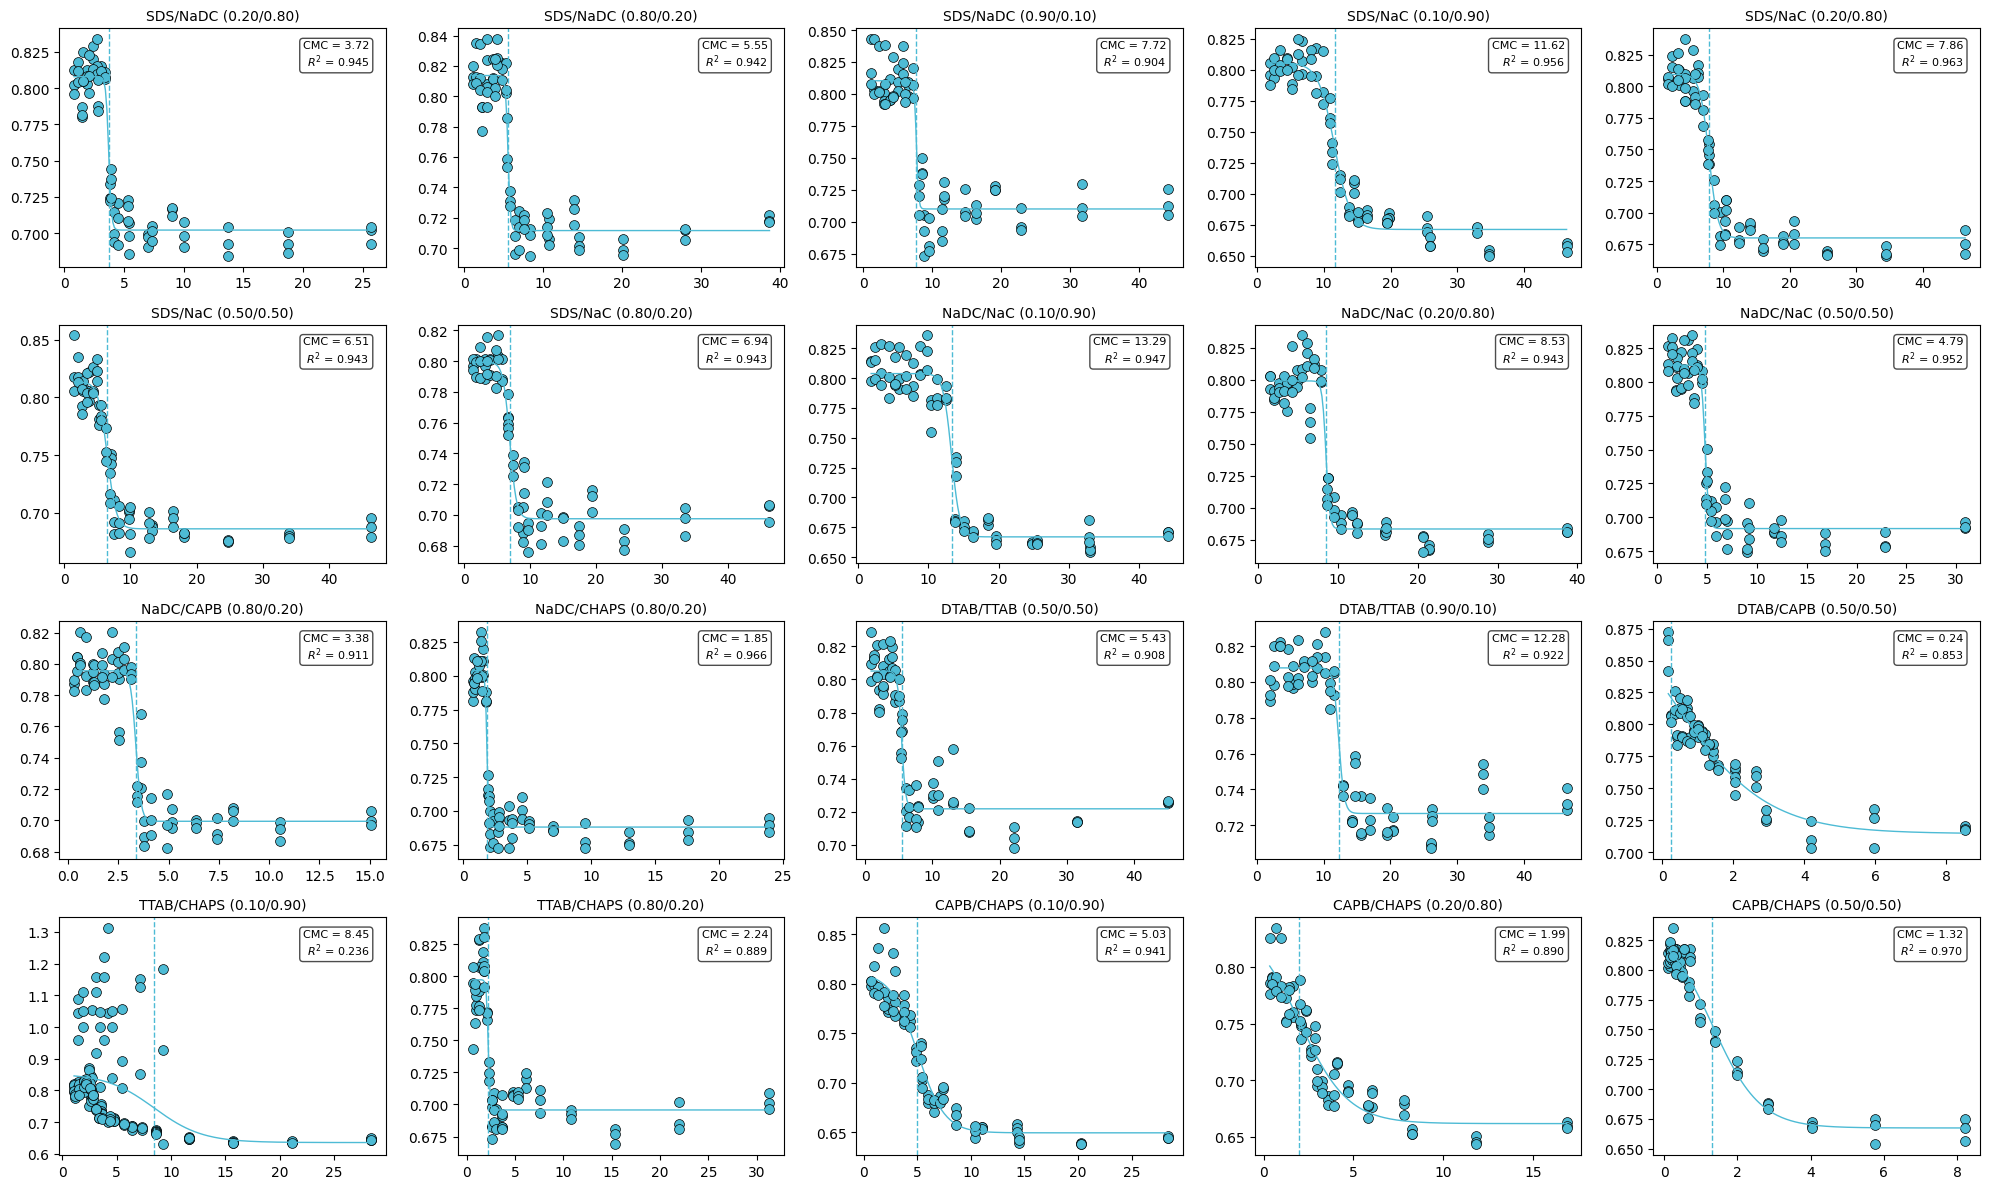

,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,CMC,R2
0,SDS,0.2,NaDC,0.8,3.720416,0.945477
1,SDS,0.8,NaDC,0.2,5.551004,0.941822
2,SDS,0.9,NaDC,0.1,7.720962,0.903710
3,SDS,0.1,NaC,0.9,11.618175,0.956259
4,SDS,0.2,NaC,0.8,7.864876,0.962520
5,SDS,0.5,NaC,0.5,6.505379,0.942552
6,SDS,0.8,NaC,0.2,6.940326,0.942800
7,NaDC,0.1,NaC,0.9,13.290888,0.946806
8,NaDC,0.2,NaC,0.8,8.534472,0.942611
9,NaDC,0.5,NaC,0.5,4.788000,0.951762


In [7]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Boltzmann sigmoidal function
def boltzmann(x, A1, A2, x0, dx):
    return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))

# CMC_plot function as provided
def CMC_plot(ax, ratio, conc, log=0, plot=1):
    if log:
        conc = np.log(conc)

    p0 = [
        max(ratio),
        min(ratio),
        (max(conc) + min(conc)) / 2,
        (max(conc) - min(conc)) / 5
    ]
    popt, _ = curve_fit(boltzmann, conc, ratio, p0, maxfev=5000)
    A1, A2, x0, dx = popt

    # compute R²
    residuals = ratio - boltzmann(conc, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ratio - np.mean(ratio))**2)
    r2 = 1 - ss_res / ss_tot

    if plot:
        x_fit = np.linspace(min(conc), max(conc), 200)
        ax.scatter(
            conc,
            ratio,
            s=50,
            facecolors=blue,
            edgecolors='black',
            linewidth=0.5
        )
        ax.plot(
            x_fit,
            boltzmann(x_fit, *popt),
            color=blue,
            lw=1
        )
        ax.axvline(
            x0,
            linestyle='--',
            color=blue,
            lw=1
        )
        if log:
            x0 = math.exp(x0)
        ax.text(
            0.95, 0.95,
            f"CMC = {x0:.2f}\n$R^2$ = {r2:.3f}",
            transform=ax.transAxes, ha='right', va='top',
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
        )
    return x0, r2

# Assuming `combined_full` is loaded and passed as `df`
COMBINE_ASSAYS = True

df = combined_full.copy()

# Column definitions
I1_COL = '334_373'
I3_COL = '334_384'
RATIO_COL = 'ratio'
SURF_1_COL = 'surfactant_1'
SURF_1_RATIO_COL = 'surfactant_1_ratio'
SURF_2_COL = 'surfactant_2'
SURF_2_RATIO_COL = 'surfactant_2_ratio'
ASSAY_COL = 'assay'
CONC_COL = 'concentration'

# Ensure ratio columns are numeric
df[SURF_1_RATIO_COL] = pd.to_numeric(df[SURF_1_RATIO_COL], errors='coerce')
df[SURF_2_RATIO_COL] = pd.to_numeric(df[SURF_2_RATIO_COL], errors='coerce')

# Surfactant ordering
SURFACTANT_ORDER = ['SDS', 'NaDC', 'NaC', 'CTAB', 'DTAB', 'TTAB', 'CAPB', 'CHAPS']
df[SURF_1_COL] = pd.Categorical(df[SURF_1_COL], categories=SURFACTANT_ORDER, ordered=True)
df[SURF_2_COL] = pd.Categorical(df[SURF_2_COL], categories=SURFACTANT_ORDER, ordered=True)

# Identify unique surfactant combinations (including ratios)
combos = (
    df[[SURF_1_COL, SURF_2_COL, SURF_1_RATIO_COL, SURF_2_RATIO_COL]]
      .drop_duplicates()
      .sort_values([SURF_1_COL, SURF_2_COL, SURF_1_RATIO_COL])
      .reset_index(drop=True)
)

# Prepare subplots
nplots = len(combos)
ncols = 5
nrows = int(np.ceil(nplots / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)

# -- NEW: prepare to collect CMC & R2 results --
results = []

# Loop through each combination
for idx, combo in combos.iterrows():
    surf1 = combo[SURF_1_COL]
    surf2 = combo[SURF_2_COL]
    # Cast ratios to float for formatting
    r1 = float(combo[SURF_1_RATIO_COL])
    r2 = float(combo[SURF_2_RATIO_COL])
    ax = axes[idx // ncols, idx % ncols]

    # Filter data for this specific combo
    sub = df[
        (df[SURF_1_COL] == surf1) &
        (df[SURF_2_COL] == surf2) &
        (df[SURF_1_RATIO_COL] == r1)
    ]
    conc = sub[CONC_COL].values
    ratio_vals = sub[RATIO_COL].values

    # Generate plot and capture CMC & R2
    cmc, r2_fit = CMC_plot(ax, ratio_vals, conc, log=0, plot=1)
    ax.set_title(f"{surf1}/{surf2} ({r1:.2f}/{r2:.2f})", fontsize=10)

    # -- NEW: append this combo's results --
    results.append({
        SURF_1_COL:       surf1,
        SURF_1_RATIO_COL: r1,
        SURF_2_COL:       surf2,
        SURF_2_RATIO_COL: r2,
        'CMC':            cmc,
        'R2':             r2_fit
    })

# Disable any unused subplots
for j in range(nplots, nrows * ncols):
    axes[j // ncols, j % ncols].axis('off')

plt.tight_layout()
plt.show()

# -- NEW: create a DataFrame of the results --
results_df = pd.DataFrame(results)
fig.savefig('Figure_4a.png', dpi=300)
results_df

In [8]:
single_cmc = pd.read_excel("/Users/zeqing/0_Github/SDL5_CMC/Table_1.xlsx")
single_cmc

,surfactant,replicate CV,assay CV,time CV,overall CV,measured CMC,measured CMC STD,literature low,literature high
0,SDS,0.02,0.03,0.02,0.03,8.63,0.24,7.00,10.00
1,NaDC,0.01,0.01,0.01,0.02,5.50,0.09,2.48,8.20
2,NaC,0.03,0.04,0.03,0.04,14.99,0.64,13.00,15.00
3,CTAB,0.02,0.06,0.02,0.05,1.10,0.06,0.90,1.24
4,DTAB,0.03,0.03,0.04,0.04,14.87,0.65,15.70,16.00
5,TTAB,0.01,0.02,0.02,0.03,3.83,0.11,3.77,4.20
6,CAPB,-0.48,0.18,-13.27,-73.92,-0.02,1.68,0.28,0.97
7,CHAPS,0.03,0.09,0.03,0.08,6.86,0.54,6.00,10.00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cmc_vs_surf1_ratio(results_df, single_cmc_df, ncols=5):


    s1 = 'surfactant_1'
    s2 = 'surfactant_2'
    rat = 'surfactant_1_ratio'
    cmc = 'CMC'
    surf = 'surfactant'
    meas = 'measured CMC'

    # build lookup for pure compounds
    cmc_lookup = single_cmc_df.set_index(surf)[meas].to_dict()

    # find all unique combos
    combos = results_df[[s1, s2]].drop_duplicates().reset_index(drop=True)
    nplots = len(combos)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*4, nrows*3),
                             squeeze=False)

    for idx, combo in combos.iterrows():
        surf1 = combo[s1]
        surf2 = combo[s2]
        ax = axes[idx // ncols, idx % ncols]

        # mixture data
        sub = results_df[(results_df[s1]==surf1)&(results_df[s2]==surf2)]
        x_mix = sub[rat].values
        y_mix = sub[cmc].values

        # pure endpoints
        y0 = cmc_lookup.get(surf2, np.nan)  # at ratio 0
        y1 = cmc_lookup.get(surf1, np.nan)  # at ratio 1

        # combine and sort
        x_all = np.concatenate(([0], x_mix, [1]))
        y_all = np.concatenate(([y0], y_mix, [y1]))
        order = np.argsort(x_all)
        x_all, y_all = x_all[order], y_all[order]

        # single line+marker plot
        ax.plot(
            x_all, y_all,
            linestyle='-',
            color=blue,              # line color
            marker='o',
            markersize=8,
            markerfacecolor=blue,    # fill color of the markers
            markeredgecolor='black',   # border color of the markers
            markeredgewidth=0.5,       # border width of the markers
            label=f"{surf1}/{surf2}"
        )

        ax.set_title(f"{surf1}/{surf2}", fontsize=10)
        ax.set_xlabel(f"{surf1} Ratio", fontsize=10)
        ax.set_ylabel('CMC (mM)')
#        ax.grid(True, linestyle='--', alpha=0.5)
#        ax.legend(fontsize=6, loc='best')

    # turn off any empty subplots
    for j in range(nplots, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    fig.savefig('Figure_4b.png', dpi=300)
    plt.show()


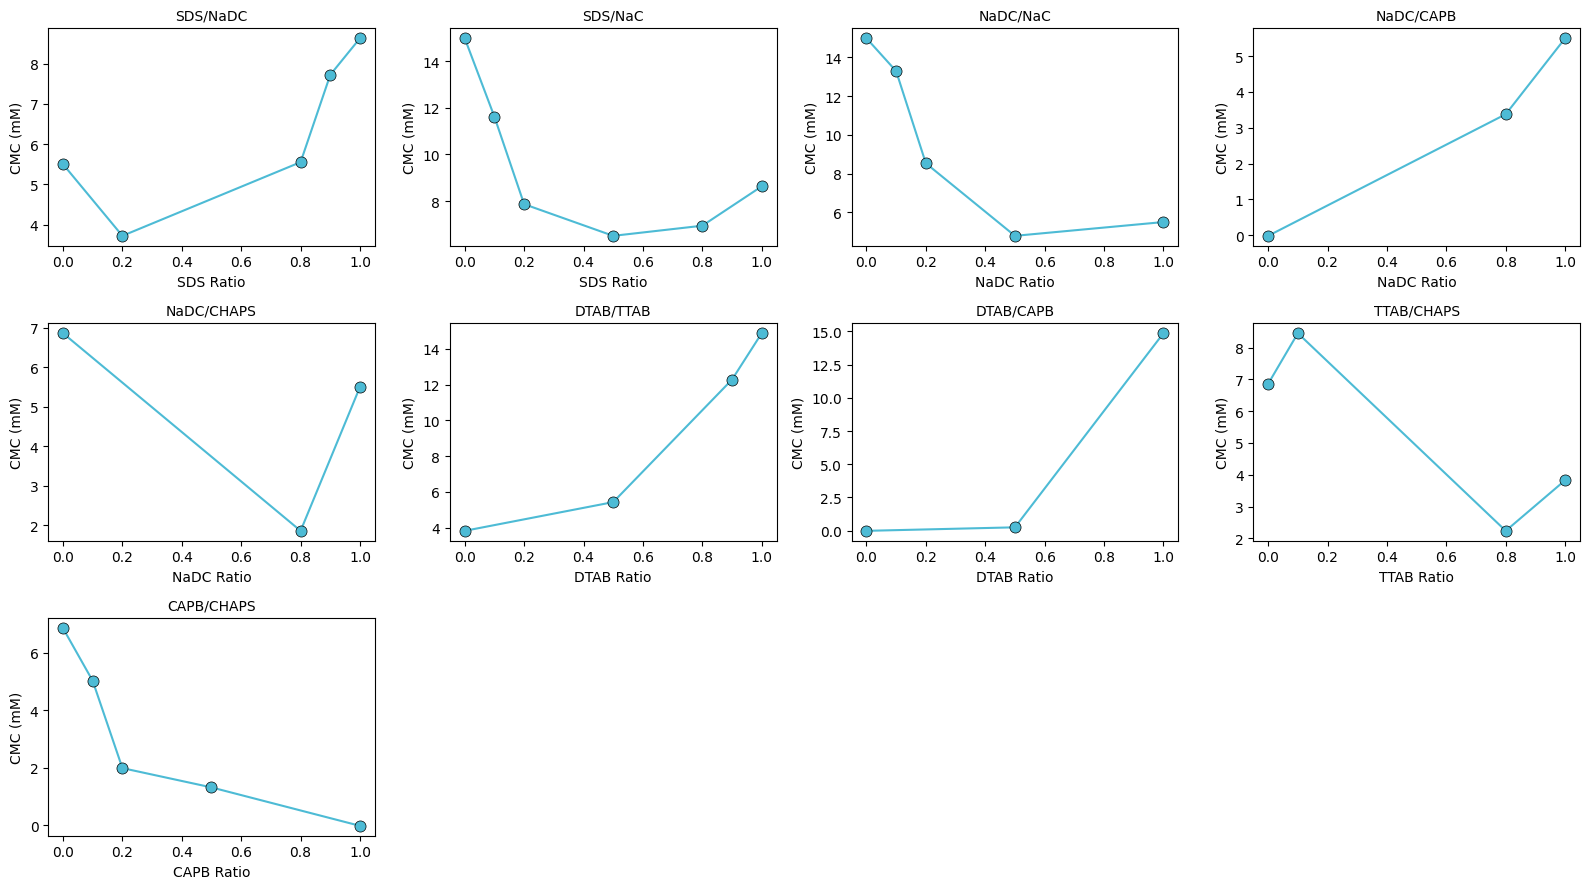

In [10]:
plot_cmc_vs_surf1_ratio(results_df, single_cmc, ncols=4)


In [11]:
results_df

,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,CMC,R2
0,SDS,0.2,NaDC,0.8,3.720416,0.945477
1,SDS,0.8,NaDC,0.2,5.551004,0.941822
2,SDS,0.9,NaDC,0.1,7.720962,0.903710
3,SDS,0.1,NaC,0.9,11.618175,0.956259
4,SDS,0.2,NaC,0.8,7.864876,0.962520
5,SDS,0.5,NaC,0.5,6.505379,0.942552
6,SDS,0.8,NaC,0.2,6.940326,0.942800
7,NaDC,0.1,NaC,0.9,13.290888,0.946806
8,NaDC,0.2,NaC,0.8,8.534472,0.942611
9,NaDC,0.5,NaC,0.5,4.788000,0.951762
